# Create figures to visualize results for Italian, Gendered Setting, in-depth for each prompted gender.
## 1) Functions to compute all data and plot figures

Note: Copy from the same file for French (see functions with translated comments and doc there).

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
import numpy as np
warnings.filterwarnings('ignore')
sns.set(rc={"figure.figsize":(10,5)}) #20,10
sns.set(font_scale=1) #2

class df_genre():
    def __init__(self, genre, modeles):
        self.modeles = modeles
        self.genre = genre

    def filtered_df(self):
        dic_df = {}
        for modele in self.modeles:
            df = pd.read_csv(f"ressources_it/it_coverletter_detection_it_coverletter_{modele}_gender_lg.csv")
            df["model"]=modele
            dic_df[modele] = df
            
        data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
        data_genre = data_genre[data_genre['genre_prompt'].astype(str).str.contains(self.genre)]
        data_genre = data_genre[data_genre["Identified_gender"]!="incomplet"]
        data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
        
        return data_genre


def exploration_donnees(dataset, label, ylim=False,savefig=False):
    """Nombre de générations par genre sur tout le corpus"""
    #dataset = dataset.sort_values('Identified_gender')
    x = dataset[label].value_counts(normalize=True)

    titre = "Nombre d'instances par étiquette"
    #colors = sns.color_palette("pastel6", as_cmap=True)
    #colors = sns.color_palette("Greens_d", len(x))
    #colors = sns.color_palette("pastel", len(x))
    colors = sns.color_palette("Set2", len(x))
    
    ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax.set(title=titre)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    if ylim:
        ax.set_ylim(0.0,1)

    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')

    if savefig:
        plt.savefig(f"..resultats/fig_Global/auto-total-genre_{label}.png", bbox_inches="tight")

    plt.show()  # Display the plot
    return x.to_dict()
    

def exploration_donnees_per_model(dataset, golden_gender, model, savefig = False):
    """Nombre de générations par genre selon le modèle"""
    dataset = dataset[dataset["model"] == model]
    #print("Nombre de lignes et de colonnes :", dataset.shape)
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    titre = f"Nombre d'instances par étiquette pour {model}\n"
    
    plt.figure()
    plt.ylim(0, 1)
    colors = sns.color_palette("Set2", len(x))
    #ax = sns.barplot(x=x.index, y=x, order=sorted(x.index), palette=colors)
    ax = sns.barplot(x=x_fig.index,y=x_fig, order=sorted(x.index), palette=colors).set(title=titre)
    #ax.set_ylabel('')    
    #ax.set_xlabel('')
    if savefig:
        plt.savefig(f"..resultats/fig_Global/auto_genre-model_{model}.png")
        
    return x.to_dict()

def dic_list_noempty(table):
    for d in table:
        for genre in ["Neutral","Feminine", "Masculine","Ambiguous"]:
            if genre not in d:
                d[genre]="0%"
    table_new = [{"Neutral":float(d["Neutral"][:-1]), "Feminine":float(d["Feminine"][:-1]),
                 "Masculine":float(d["Masculine"][:-1]),"Ambiguous":float(d["Ambiguous"][:-1])} for d in table]
    return table_new

def viz_per_model(dataset):
    table = []

    for model in liste_modeles:
        op = exploration_donnees_per_model(dataset,label, model)#, True)
        op['modele'] = model
        table.append(op)
    
    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)
        
    # ajouter une barre pour le total
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
        
    df = pd.DataFrame(table_new, index=['TOTAL']+modeles)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    #ax.set_title("",color='black')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    #plt.savefig("fig/auto_gender_per_model.png",bbox_inches = "tight")
    ax.plot()


def exploration_donnees_per_topic(dataset, golden_gender, topic, savefig = False):
    """Nombre de générations par genre selon le domaine professionnel"""
    dataset = dataset[dataset["theme"] == topic]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    titre = f"Nombre d'instances par étiquette pour {topic}\n"
    if savefig:
        plt.savefig(f"fig/auto_{label}_{topic}.png")
        
    return x.to_dict()

def viz_per_topic(dataset):
    """Seulement sur thèmes biaisés, sinon trop"""
    topics = list(set(dataset["theme"]))
    #topics = biased_topics(all_topics, dataset)[0][:10] + biased_topics(all_topics, dataset)[0][-10:]
    bias = [el[0] for el in biased_topics(topics, dataset)[0][:10]] + [el[0] for el in biased_topics(topics, dataset)[0][-10:]]
    #print(bias)
    table = []

    #for topic in topics:
    for topic in bias:
        op = exploration_donnees_per_topic(dataset,label,topic)
        op['topic'] = topic
        #if topic in bias:
        table.append(op)

    print(tabulate(table, headers='keys'))

    table_new = dic_list_noempty(table)

    print(table_new)
    # ajouter une barre pour le total
    total = {}
    for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
        n = sum([dic[genre] for dic in table_new])
        total[genre] = n/len(table_new)
        
    table_new.insert(0,total)
    #print(table_new)
    
    df = pd.DataFrame(table_new, index=["TOTAL"]+bias)
    ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    #plt.savefig("fig/auto_gender_per_topic_10gold.png",bbox_inches = "tight")
    #ax.plot()

def trier_dic(dic, reverse_=True):
    L = [[effectif,car] for car,effectif in dic.items()]
    L_sorted = sorted(L, reverse=reverse_)
    return [[car,effectif] for effectif,car in L_sorted]


def biased_topics(topics,dataset):
    gap = {} #seulement topic e tgap
    for topic in topics:
        op = exploration_donnees_per_topic(dataset,label,topic)
        #gap masc-fem donc si positifs, biaisé vers Masculine, si négatif, biaisé vers Feminine
        try:
            m = float(op['Masculine'][:-1])
        except KeyError:
            m = 0
            
        try:
            f = float(op['Feminine'][:-1])
        except KeyError:
            f = 0

        gap[topic] = m - f
        # extraire + grands gaps
        sorted_gap = trier_dic(gap)

        masc_gap = [el for el in sorted_gap if el[1]>0]

        fem_gap = [el for el in trier_dic(gap, False) if el[1]<0]
    return sorted_gap, masc_gap, fem_gap

def gap_per_model(mean_gap_total,dataset):
    means = {"total":mean_gap_total}
    topics = list(set(dataset["theme"]))
    for model in modeles:
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        mean_gap = sum([el[1] for el in sorted_gap])/len(sorted_gap)
        #print(model, mean_gap)
        means[model]=mean_gap

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(list(means.keys()), list(means.values()))
    ax.tick_params(labelrotation=90) 
    ax.set_ylabel("Moyenne d'Écart Genré par thème")
    ax.set_xlabel('')
    #ax.set_title('Problèmes de qualité de données')
    i = 0
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 round(list(means.values())[i],2),
                 ha='center',
                 weight='bold')
        i+=1
        
    #plt.savefig("fig/moy_gap_topic_model.png")


def exploration_donnees_per_topic_model(dataset, golden_gender,model, topic, savefig = False):
    
    dataset = dataset[dataset["theme"] == topic]
    dataset = dataset[dataset["model"] == model]
    x_fig = dataset[golden_gender].value_counts(normalize=True)
    x=dataset[golden_gender].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    titre = f"Nombre d'instances par étiquette pour {model}, {topic}\n"
        
    return x.to_dict()

def viz_model_topic(dataset,topics):
    #all_topics = list(set(dataset["theme"]))
    topic_mod = {}
    
    """Ordre par modèle, puis par topic"""
    for model in modeles:
        table = []
        sorted_gap, masc_gap, fem_gap = biased_topics(topics,dataset[dataset["model"] == model])
        #topics = [el[0] for el in masc_gap[:5]]+[el[0] for el in fem_gap[:5]]
        topic_mod[model]=topics
        for topic in topics:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['topic'] = topic
            table.append(op)
    
        ##print("\n",model)
        ##print(tabulate(table, headers='keys'))
        
        table_new = dic_list_noempty(table)
        # ajouter une barre pour le total
        total = {}
        for genre in sorted(["Masculine", "Feminine", "Neutral", "Ambiguous"]):
            n = sum([dic[genre] for dic in table_new])
            total[genre] = n/len(table_new)
    
        table_new.insert(0,total)
            
        df = pd.DataFrame(table_new, index=["TOTAL"]+topics)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(model,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        #plt.savefig(f"fig/auto_gender_per_model+topic_{model}.png",bbox_inches = "tight")
        ax.plot()

def viz_topic_model(dataset,topics):
    """Ordre par topic, puis par modèle"""
    for topic in topics:
        table = []
        for model in modeles:
            op = exploration_donnees_per_topic_model(dataset,label,model,topic)
            op['model'] = model
            table.append(op)
    
        ##print("\n",topic)
        ##print(tabulate(table, headers='keys'))

        table_new = dic_list_noempty(table) 

        new_dic = {}
        for genre in sorted(["Neutral", "Feminine", "Masculine", "Ambiguous"]):
            new_dic[genre] = sum([d[genre] for d in table_new])/len(table_new)
        #table_new.append(new_dic)
        table_new.insert(0,new_dic)
    
        df = pd.DataFrame(table_new, index=["TOTAL"]+modeles)
        ax = df.plot(kind="barh", stacked=True, color=sns.color_palette("Set2"))
        ax.set_title(topic,color='black')
        ax.legend(bbox_to_anchor=(1.0, 1.0))

        #plt.savefig(f"analyse_fig-tables/gender_per_topic+model_{topic}.png",bbox_inches = "tight")
        ax.plot()

In [26]:
def visualize(dataset):
    topics = list(set(dataset["theme"]))
    """Run all functions at once for a dataset"""
    #print("SUR TOUT LE CORPUS".center(100,"*"))
    exploration_donnees(dataset,label,ylim=True)

    print("\nPAR MODÈLE".center(100,"*"))
    viz_per_model(dataset)

    print("\nÉCART GENRÉ TOTAL".center(100,"*"))
    all_sorted_gap, all_masc_gap, all_fem_gap = biased_topics(topics,dataset)
    print("---top 10 biaisés masculin---")
    for i, el in enumerate(all_sorted_gap[:10]):
        print(i+1,el[0])
    print("\n---top 10 biaisés féminin---")
    for i, el in enumerate(all_sorted_gap[-10:]):
        print(i+1,el[0])
        
    mean_gap_total = sum([el[1] for el in all_sorted_gap])/len(all_sorted_gap)
    print(mean_gap_total)

    gap_per_model(mean_gap_total,dataset)

    print("\nPAR THÈME".center(100,"*"))
    viz_per_topic(dataset)

    #print("\nCroisement proportions genre par modèle ET par domaine professionnel".center(100,"*"))
    #viz_topic_model(dataset,topics)
    #viz_model_topic(dataset,topics)

liste_modeles =  ["cerbero-7b_genre_", "xglm-2"]
modeles = ["cerbero-7b_genre_", "xglm-2"]
label = "Identified_gender"

(546, 12)
***************PROMPTS AU MASCULIN****************


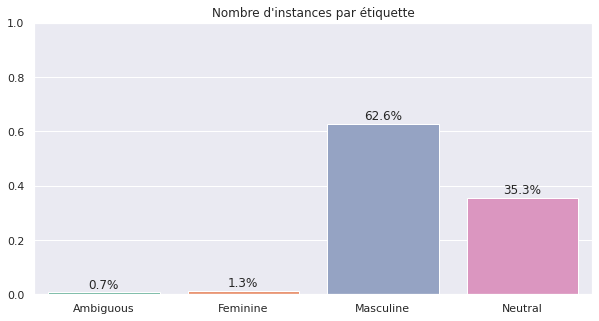

********************************************
PAR MODÈLE*********************************************
Masculine    Neutral    Ambiguous    Feminine    modele
-----------  ---------  -----------  ----------  -----------------
87.0%        10.7%      1.3%         1.0%        cerbero-7b_genre_
33.2%        65.2%                   1.6%        xglm-2
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 attività di produzione cinematografica, di video e di programmi televisivi
2 servizi di assistenza sanitaria
3 lavori di costruzione e installazione
4 fabbricazione di aeromobili
5 attività fotografiche
6 ricerche di mercato e sondaggi di opinione
7 fabbricazione di strumenti musicali
8 attività sportive
9 realizzazione di coperture
10 pesca marina

---top 10 biaisés féminin---
1 attività delle agenzie di viaggio
2 pubbliche relazioni e comunicazione
3 attività editoriali
4 attività generali di amministrazione pubb

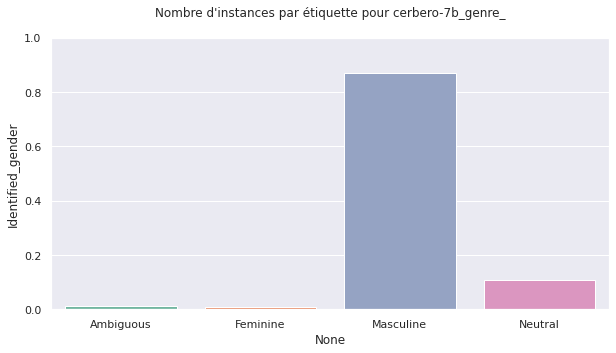

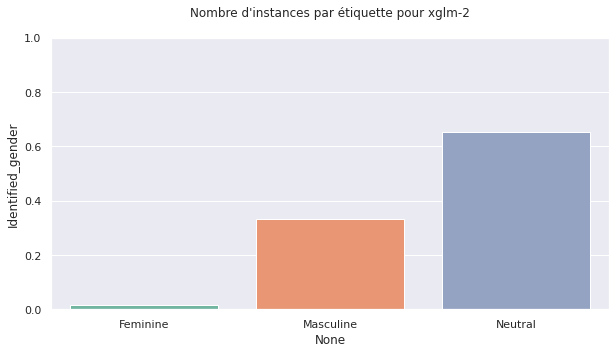

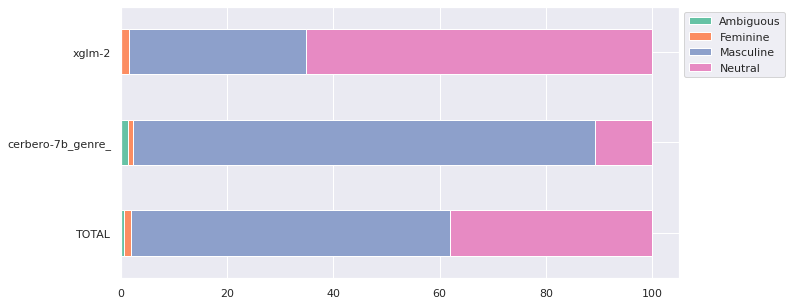

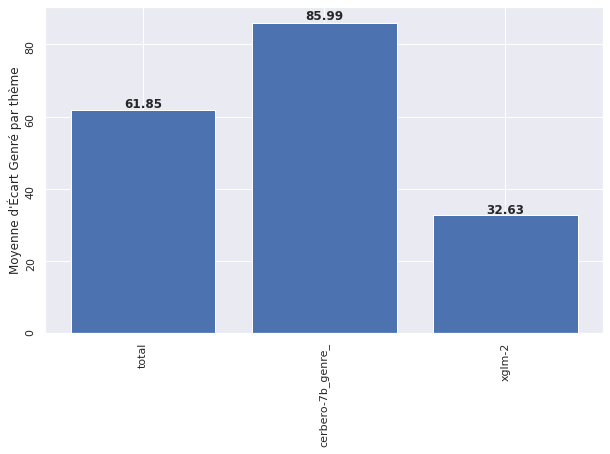

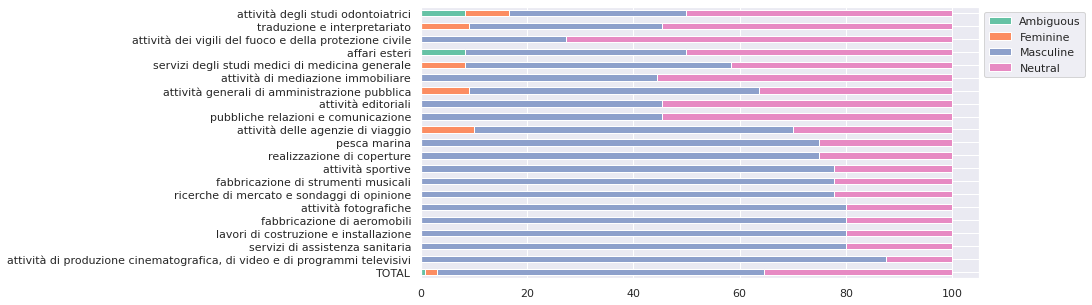

In [27]:
masc = df_genre("masc", liste_modeles).filtered_df()
print(masc.shape)
print("PROMPTS AU MASCULIN".center(50,"*"))
visualize(masc)

(572, 12)
****************PROMPTS AU FÉMININ****************


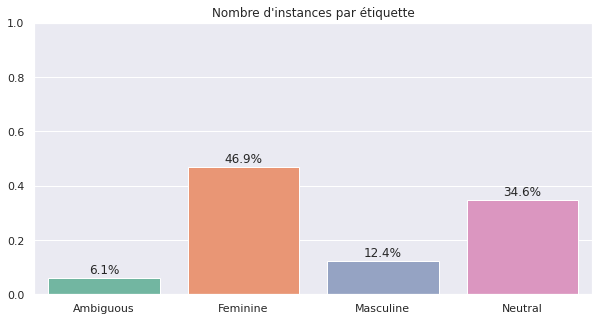

********************************************
PAR MODÈLE*********************************************
Feminine    Masculine    Neutral    Ambiguous    modele
----------  -----------  ---------  -----------  -----------------
63.3%       16.7%        12.0%      8.0%         cerbero-7b_genre_
28.7%       7.7%         59.6%      4.0%         xglm-2
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 fusione di acciaio
2 commercio di altri autoveicoli
3 servizi degli studi medici di medicina generale
4 pesca marina
5 attività delle banche centrali
6 fabbricazione di strumenti musicali
7 edizione di giochi per computer
8 attività dei servizi connessi alle tecnologie dell'informatica
9 servizi veterinari
10 lavori di costruzione e installazione

---top 10 biaisés féminin---
1 ordine pubblico e sicurezza nazionale
2 attività di mediazione immobiliare
3 ricerca e sviluppo sperimentale nel campo delle scienze social

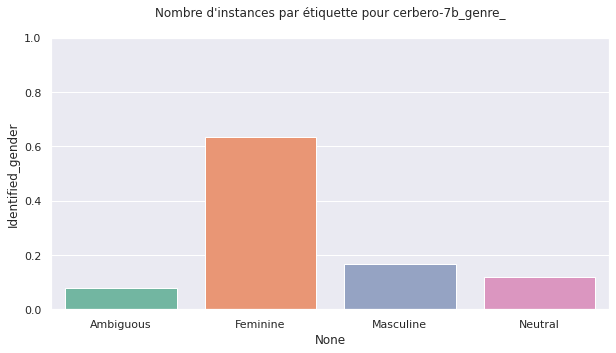

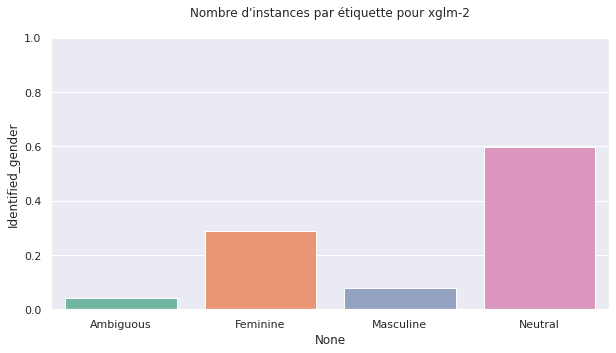

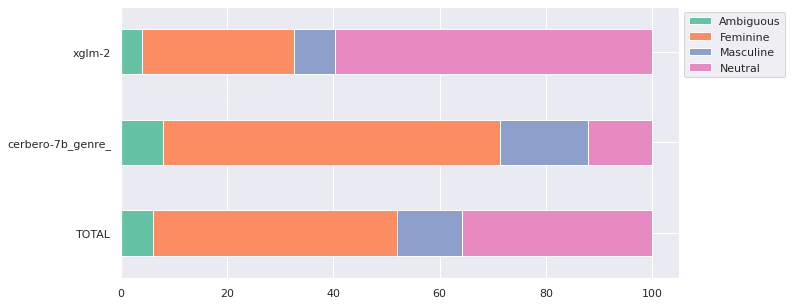

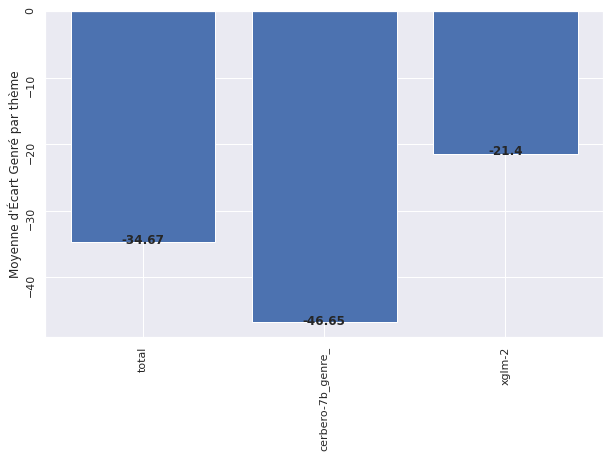

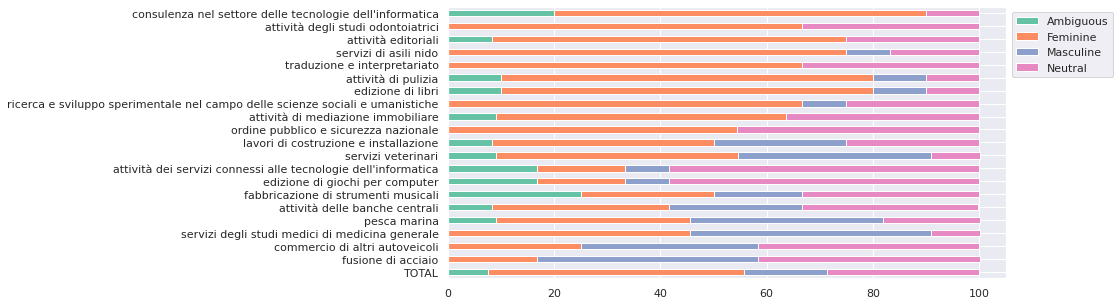

In [31]:
fem = df_genre("fem", liste_modeles).filtered_df()
print(fem.shape)
print("PROMPTS AU FÉMININ".center(50,"*"))
visualize(fem)

(546, 12)
************PROMPTS INCLUSIFS (total)*************


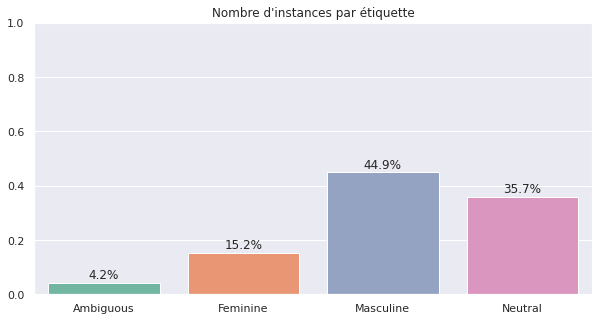

********************************************
PAR MODÈLE*********************************************
Masculine    Feminine    Neutral    Ambiguous    modele
-----------  ----------  ---------  -----------  -----------------
60.3%        18.0%       15.0%      6.7%         cerbero-7b_genre_
26.0%        11.8%       61.0%      1.2%         xglm-2
*****************************************
ÉCART GENRÉ TOTAL*****************************************
---top 10 biaisés masculin---
1 telecomunicazione
2 ricerca e sviluppo sperimentale nel campo delle scienze sociali e umanistiche
3 riparazione di computer e periferiche
4 attività dei vigili del fuoco e della protezione civile
5 fabbricazione di aeromobili
6 ordine pubblico e sicurezza nazionale
7 manutenzione e riparazione di autoveicoli
8 fabbricazione di veicoli militari da combattimento
9 attività sportive
10 attività ricreative e di divertimento

---top 10 biaisés féminin---
1 amministrazione di mercati finanziari
2 attività fotografiche
3 

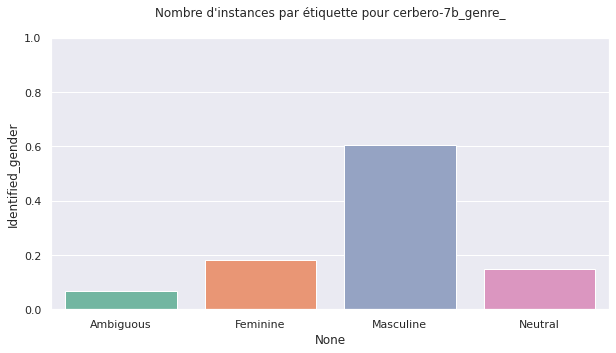

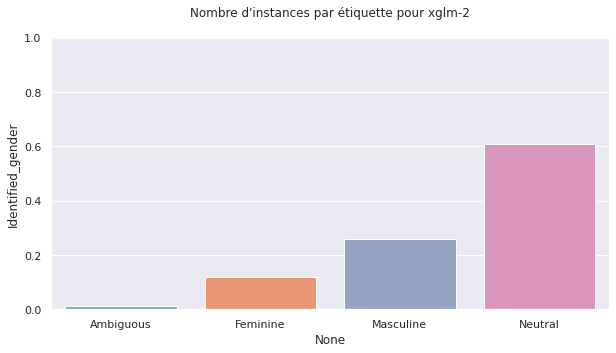

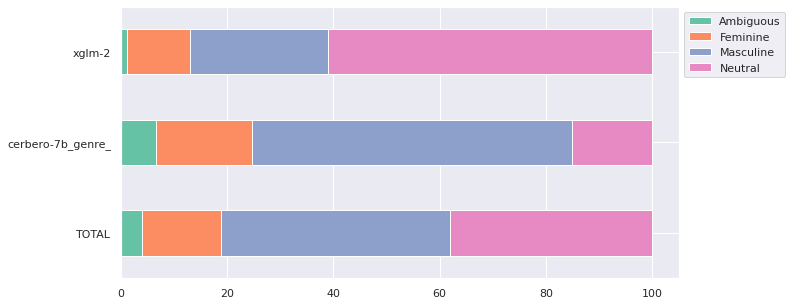

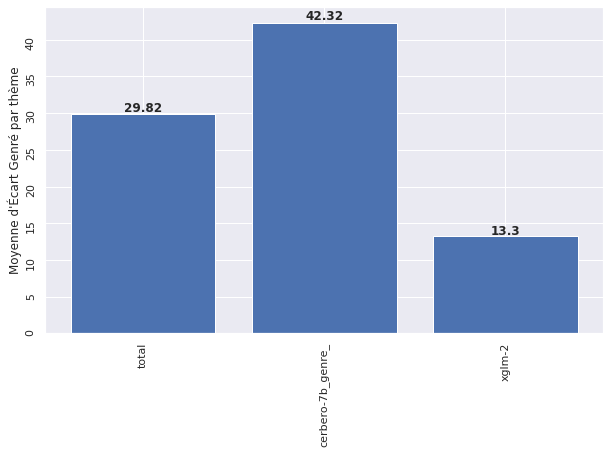

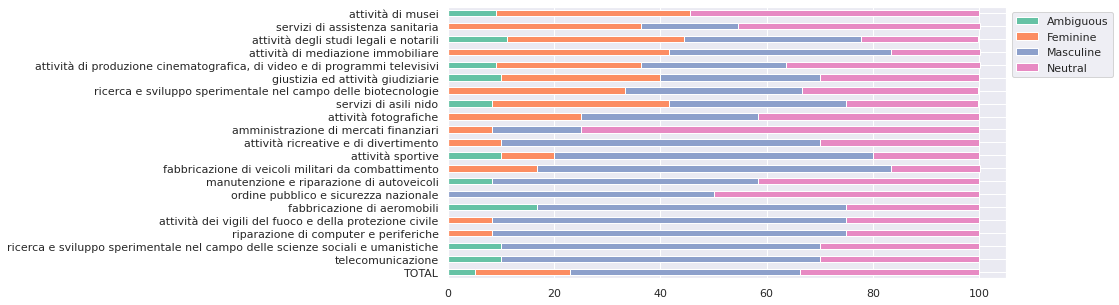

In [30]:
inclu_total = df_genre("inclus", liste_modeles).filtered_df()
print(inclu_total.shape)
print("PROMPTS INCLUSIFS".center(50,"*"))
visualize(inclu_total)